# Component Lineage for Ascend from Python

This notebook demonstrates how to use the 
[Ascend SDK for Python](https://github.com/ascend-io/ascend-python-sdk) to report on the lineage of your Components.

## Configuration

> If you are not already an Ascend user you can [Request a Free Trial](https://www.ascend.io/get-started/)

This notebook will connect to your Ascend environment via a Web API using a Service Account you create for in the Ascend UI.

If you are using the `trial.ascend.io` environment, you will not be able to create a Service Account for the 
Data Service **Getting Started with Ascend**, so change `DATA_SERVICE` to the `id` of your Data Service.
You may want to [import the `Tutorial` Dataflow](https://developer.ascend.io/docs/exporting-importing) in your Data Service first so that you can follow along with the examples here.

If you are not on `trial.ascend.io`, change `host` to the hostname of your Ascend environment,
and (optionally) modify the `profile` under which your credentials are stored.


In [1]:
host = "gcp-dev.ascend.io"
DATA_SERVICE = 'Getting_Started_with_Ascend'
DATAFLOW = 'Advanced_Tutorial'
SOURCE_COMPONENT = 'Yellow_Cabs'
SOURCE_COLUMN = 'tpep_dropoff_datetime'

DEST_COMPONENT = 'NYC_Cab_rides_on_rainy_days'
DEST_COLUMN = 'fare_amount'

SQL_COMPONENT = '_clean_Yellow_Cabs'

SINK_COMPONENT = 'Cab_Rides_GCS'
DATA_FEED = 'NYC_Cab_rides_on_rainy_days_data_feed'

## Credentials

To run this notebook, access Data Feeds from Python, you will need

  * a Service Account with `READ ONLY` permission
  * an Access Key ID and Secret for that Service Account

**OR**

  * an Access Key ID and Secret for a user with at least `Read Only` permission

You can create service account keys in the Ascend UI by going to **Data Service > Service Accounts**.
If you are using `trial.ascend.io`, create the Service Account in your own Data Service.
Otherwise, select the Data Service **Getting Started with Ascend** and create a Service Account there.

You can create user access keys in the Ascend UI by going to the **User Dropdown > Access Keys**.

Access Keys should not be stored in a notebook. 
Instead, this notebook will look for them in `~/.ascend/credentials` on the machine where your Jupyter server is running.
Your `~/.ascend/credentials` file should look like this (substitute your Ascend Access Key ID and Secret Access Key):
```
[trial]
ascend_access_key_id=Y0URACC355K3Y1D
ascend_secret_access_key=yourSecret!AccessKeyisthelong1
```

Once you have a `credentials` file, you can read it with `configparser` and
create a `Client` to connect to the host using your credentials.

In [2]:
from ascend.client import Client
from IPython.display import Image

A = Client.build(host)
A


# The Lineage Object
Use the `<Client>.get_lineage()` method to produce a Lineage object, which handles the lineage api in Ascend for you.

Use the `<Lineage>.columns(<Component>)` method to display the columns produced by a component.

In [3]:
import ascend.lineage as lin
from itertools import groupby
import random

comp = A.get_component(DATA_SERVICE, DATAFLOW, SOURCE_COMPONENT)
g = A.get_lineage()
cols = g.columns(comp)
print(f"Get columns for {comp}")
for col in cols:
    print(col.name)
    print(col.expression)


Get columns for <ascend.model.ReadConnector Getting_Started_with_Ascend.Advanced_Tutorial.Yellow_Cabs type=ReadConnector>
tpep_pickup_datetime
---
sourceName: "tpep_pickup_datetime"
targetName: "tpep_pickup_datetime"
nullIsInvalid: true
invalidValueHandling:
  suppressWarn: true
  useDefault:
    defaultValue: ""
string: {}

fare_amount
---
sourceName: "fare_amount"
targetName: "fare_amount"
invalidValueHandling:
  useDefault: {}
float: {}

dropoff_latitude
---
sourceName: "dropoff_latitude"
targetName: "dropoff_latitude"
invalidValueHandling:
  useDefault: {}
float: {}

store_and_fwd_flag
---
sourceName: "store_and_fwd_flag"
targetName: "store_and_fwd_flag"
nullIsInvalid: true
invalidValueHandling:
  suppressWarn: true
  useDefault:
    defaultValue: ""
string: {}

dropoff_longitude
---
sourceName: "dropoff_longitude"
targetName: "dropoff_longitude"
invalidValueHandling:
  useDefault: {}
float: {}

tip_amount
---
sourceName: "tip_amount"
targetName: "tip_amount"
invalidValueHandling:


## Downstream Lineage of Component


The `<Lineage>.out_edges()` method will return the connections to downstream components and columns. It will accept a `Component` plus an optional `column` string, or a lineage `Node`. It returns lineage `Edges`, which have their start and end lineage `Nodes`, as well as information about the particular `Edge`. Since a given input may be referenced multiple times in a component, there can be multiple edges with the same `start` and `end`.

In [4]:
import ascend.lineage as lin
from itertools import groupby
def print_lineage_downstream(component, colname):
    builder = A.get_lineage()
    visited = {}
    
    def print_recursive(component, colname, expression, leader, from_id=False, d=0):
        id = component.component_id + ('.' + colname if colname else '')
        # only recurse if we are at a column
        if colname is None:
            visited[id] = from_id
        print (leader + ('━ ' if len(leader) > 0 else '') + id)
        edges = [
            (end, list(end_edges)) for end, end_edges in 
             groupby((e for e in builder.out_edges(component, colname) if isinstance(e.end, object)),
                     lambda e: e.end)
        ]

        last = len(edges) - 1
        leader = leader.replace('┗', ' ').replace('┣','┃') + ('   ' if len(leader) > 0 else '')
 
        for line in expression:
            print((leader + ('  ' if id in visited or last == -1 else '┃ ') + line))

        
        if id not in visited:
            visited[id] = from_id
            for i, (end, end_edges) in enumerate(edges):
                expr = end.expression
                exprs = [e.type + ' ' + e.expression for e in end_edges]
                print_recursive(
                    end.get_component,
                    end.name if isinstance(end, lin.ColumnNode) else None,
                    exprs,
                    leader + ('┗' if i == last else '┣'),
                    id,
                    d + 1
                )
            
    print_recursive(component, colname, [], '')



In [5]:
print_lineage_downstream(comp, SOURCE_COLUMN)

Yellow_Cabs.tpep_dropoff_datetime
┗━ _clean_Yellow_Cabs.dropoff_datetime
    ┃ Project On line 4, column 13
    ┗━ All_Cabs.dropoff_datetime
        ┃ Project On line 1, column 8
        ┗━ NYC_Cab_rides_on_rainy_days.dropoff_datetime
            ┃ Project On line 4, column 1
            ┗━ Cab_Rides_GCS
                  Sink dropoff_datetime


In [6]:
import pandas as pd
from pathlib import Path

def build_lineage_downstream (component, colname):
    builder = A.get_lineage()
    ref = {}
    rows = []
    
    def build_recursive(component, colname, expression, parent):
        id = component.component_id + '.' + colname
        seq = len(rows)
          
        if parent is None:
            rows.append({
                'ref': seq,
                'table.column': id,
                'type': '',
                'expression': '',
                'from': ''
            })
            
        for (i, line) in enumerate(expression):
            rows.append({
                'ref': seq + i + (1 if parent is None else 0),
                'table.column': id,
                'type': line[0],
                'expression': line[1],
                'from': parent if parent is not None else ''
            })

        edges = [
            (end, list(end_edges)) for end, end_edges in 
             groupby((e for e in builder.out_edges(component, colname) if isinstance(e.end, lin.ColumnNode)),
                     lambda e: e.end)
        ]
        last = len(edges) - 1
            
        if id not in ref:
            ref[id] = seq
            for i, (end, end_edges) in enumerate(edges):
                expr = end.expression
                exprs = [(e.type, e.expression) for e in end_edges]
                build_recursive(
                    end.get_component,
                    end.name,
                    exprs,
                    ref[id])
            
    build_recursive(component, colname, [], None)
    return pd.DataFrame.from_records(rows, index='ref', columns=['ref', 'table.column', 'type', 'expression', 'from'])




In [7]:
build_lineage_downstream(comp, SOURCE_COLUMN)

,table.column,type,expression,from
ref,,,,
0,Yellow_Cabs.tpep_dropoff_datetime,,,
1,_clean_Yellow_Cabs.dropoff_datetime,Project,"On line 4, column 13",0
2,All_Cabs.dropoff_datetime,Project,"On line 1, column 8",1
3,NYC_Cab_rides_on_rainy_days.dropoff_datetime,Project,"On line 4, column 1",2


## Define a helper method and adaptor class to integrate with pygraphviz and pandas
Using the `out_edges` function to traverse the lineage graph, we can integrate it with visualization libraries. Here is an example which produces a [pygraphviz](https://pygraphviz.github.io/) visualization while taking a successors function, as well as a basic format/label method. 

**Note: to run this you will need to install graphviz and pygraphviz. If you have problems installing you can check their documentation: http://pygraphviz.github.io/documentation/pygraphviz-1.5/install.html#quick-install**

Using this method, we can define a successors function to be used while graph processing.

In [8]:
import pygraphviz as pgv
from typing import List, Tuple
import pandas as pd
import ascend.util
class GraphNode:
    def __init__(self, orig):
        self.component = orig.get_component
        self.column = orig.name if isinstance(orig, lin.ColumnNode) else None
        self.label = f'{ascend.util.type_names[self.component.api_type]}:\n {self.component.component_id}' 
        if self.column:
            self.label = f'{self.label}.{self.column}'
        # We need to supply an id for a dot graph that is hashable,
        # so we choose to use the unique UUID
        self.id = self.component.uuid + '.' + self.column if self.column else self.component.uuid
        self.orig = orig
class GraphEdge:
    def __init__(self, expression, type=None):
        self.expression = expression
        self.type = type
        self.label = expression
        if type: 
            self.label = f'{type}: {expression}'

class DotGraphCollector:
    def __init__(self):
        self.G = pgv.AGraph(strict=False, directed=True)
        self.trunc = 250
        self.seen = set()
    def collect_graph(self, start: GraphNode, successors_fn, *args, **kwargs):
        return collect_graph(self, start , successors_fn, *args, **kwargs)
    def add_node(self, node: GraphNode):
        if node.orig not in self.seen:
            self.seen.add(node.orig)
            self.G.add_node(node.id, label=f'{node.label}:\n {node.orig.expression}'[:self.trunc])
    def add_edge(self, start: GraphNode, end: GraphNode, edge: GraphEdge):
        if (start, end, edge.type) not in self.seen:
            self.seen.add((start, end, edge.type))
            self.G.add_edge(start.id, end.id, label=edge.label[:self.trunc])
    def draw(self, path):
        self.G.layout(prog='dot')
        self.G.draw(path)
class PandasTableCollector:
    def __init__(self):
        self.rows = []
        self.nodes = {}
    def collect_graph(self, start: GraphNode, successors_fn, *args, **kwargs):
        return collect_graph(self, start , successors_fn, *args, **kwargs)
    def add_node(self, node):
        self.nodes[node.id] = node
    def add_edge(self, start, end, edge):
        start_comp = start.component.component_id
        start_col = start.column
        exp = edge.expression
        end_comp = end.component.component_id
        end_col = end.column
        self.rows.append([start_comp, start_col, exp, end_comp, end_col])
    def to_df(self):
        return pd.DataFrame(self.rows, columns = ['Start Comp', 'Start Col', 'Exp', 'End Comp', 'End Col'])

class PandasPathCollector:
    class PathNode:
        def __init__(self, n: GraphNode, prev=None, edge=None):
            self.previous = prev
            self.n = n
            if prev:
                if edge and edge.type:
                    arrow = f'--{edge.type}-->'
                else:
                    arrow = '--->'
                suffix = f' {arrow} {prev.n.label}'
            else:
                suffix = ''
            self.type = edge.type if edge else ''
            self.id = n.label + suffix
            
    def __init__(self):
        self.edges = []
        self.id_to_path_nodes = {}
        self.root = None
        self.terminals = set()
        self.seen = set()
        self.trunc = 200
    def make_df_html(self, terminal):
        path_node = terminal
        rows = []
        rows.append([terminal.n.label, terminal.n.orig.expression[:self.trunc], '-', '-', 'TERMINAL'])
        while path_node is not None:
            node = path_node.n
            start = path_node.previous.n.label if path_node.previous else 'ROOT'
            start_exp = path_node.previous.n.orig.expression[:self.trunc] if path_node.previous else '-'
            type = path_node.type if path_node.previous else '-'
            end_exp = node.orig.expression[:self.trunc]
            end = node.label
            rows.append([start, start_exp, type, end, end_exp])
            path_node = path_node.previous
        df = pd.DataFrame(reversed(rows), columns = ['start', 'start_exp', 'type', 'end', 'end_exp'])
        styler = df.style.set_caption(PandasPathCollector.PathNode(node, terminal).id)
        return styler.render()
    def collect_graph(self, start: GraphNode, successors_fn, *args, **kwargs):
        self.root = PandasPathCollector.PathNode(start)
        self.id_to_path_nodes[start.id] = {self.root.id: self.root}
        self.terminals.add(start.id)
        self.seen.add(start.id)
        return collect_graph(self, start, successors_fn, *args, **kwargs)
    def add_node(self, node):
        # only care about paths
        pass
    def add_edge(self, start, end, edge):
        if end.id not in self.seen:
            self.seen.add(end.id)
            self.terminals.add(end.id)
        self.terminals -= set([start.id])
        for start_path in self.id_to_path_nodes[start.id].values():
            end_path = PandasPathCollector.PathNode(end, start_path, edge)
            d = self.id_to_path_nodes.get(end.id, {})
            self.id_to_path_nodes[end.id] = d
            d[end_path.id] = end_path
    def to_htmls(self):
        for term in self.terminals:
            for endpoint in self.id_to_path_nodes[term].values():
                yield self.make_df_html(endpoint)
        
def outgoing_nodes(g):
    def ret(node: GraphNode) -> List[Tuple[GraphNode, GraphEdge]]:
        edges = g.out_edges(node.component, node.column) if node.column else []
        # group edges by output node and edge type
        grouped_edges = [
            (t, list(end_edges)) for t, end_edges in 
             groupby((e for e in edges), lambda e: (e.end, e.type))
        ]
        # combine expressions for the same output node and edge type
        return [
           (GraphNode(end), GraphEdge(',\n and '.join(map(lambda x: x.expression, edges)), type))
            for ((end, type), edges) in grouped_edges 
        ]
    return ret

def collect_graph(collector, start: GraphNode, successors_fn, max_depth=None):
    seen = set()
    q = [(start, 0)]
    while q:
        node, depth = q.pop()
        if node.id in seen or max_depth and depth > max_depth:
            continue
        seen.add(node.id)
        collector.add_node(node)
        for out, edge in successors_fn(node):
            q.append((out, depth+1))
            collector.add_edge(node, out, edge)
    return collector

## Visualize the Downstream Lineage of a Component 
Using the pygraphviz helper method, together with our downstream successors function, we can construct a visualization of our dependency graph.

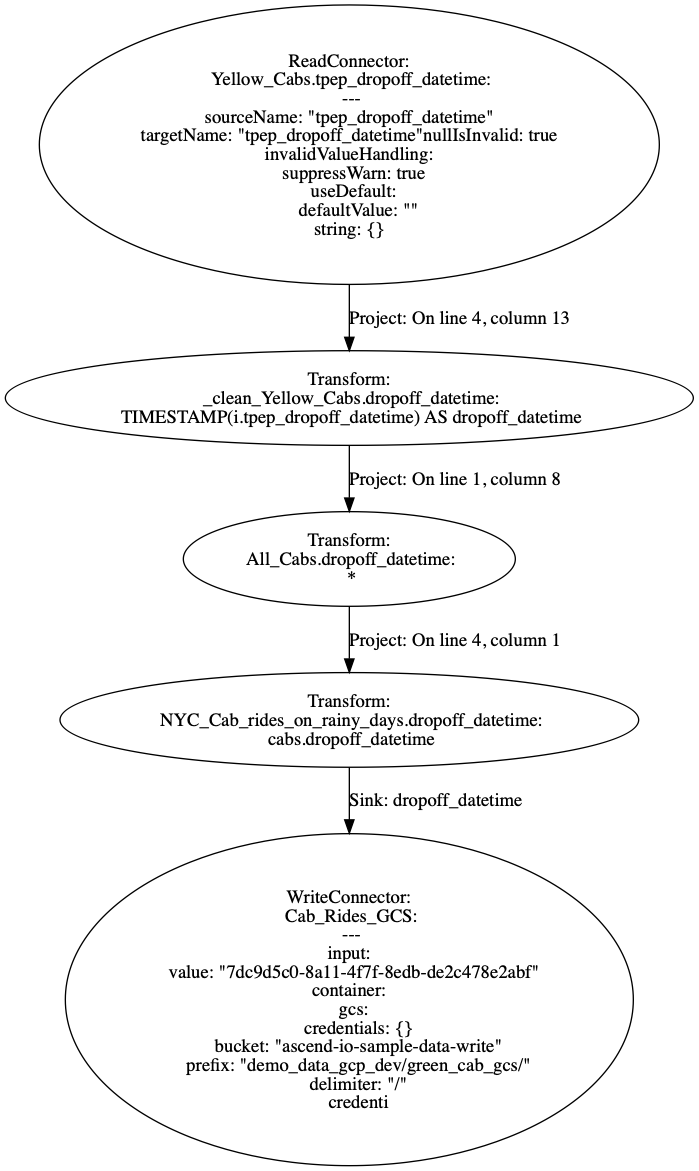

In [9]:
G = DotGraphCollector()
comp = A.get_component(DATA_SERVICE, DATAFLOW, SOURCE_COMPONENT)
start = g.make_node(component=comp, column=SOURCE_COLUMN)
G.collect_graph(GraphNode(start), outgoing_nodes(g))
G.G.graph_attr['rankdir'] = 'UD'
G.draw('downstream_lineage.png')

from IPython.display import Image
Image(filename='downstream_lineage.png')

In [10]:
from IPython.display import display, HTML

attr_build = A.get_component(DATA_SERVICE, DATAFLOW, SOURCE_COMPONENT)
G = PandasPathCollector()
G.collect_graph(GraphNode(g.make_node(component=attr_build, column=SOURCE_COLUMN)), outgoing_nodes(g))
for html in G.to_htmls(): 
    display(HTML(html))

,start,start_exp,type,end,end_exp
0,ROOT,-,-,ReadConnector: Yellow_Cabs.tpep_dropoff_datetime,"--- sourceName: ""tpep_dropoff_datetime"" targetName: ""tpep_dropoff_datetime"" nullIsInvalid: true invalidValueHandling: suppressWarn: true useDefault: defaultValue: """" string: {}"
1,ReadConnector: Yellow_Cabs.tpep_dropoff_datetime,"--- sourceName: ""tpep_dropoff_datetime"" targetName: ""tpep_dropoff_datetime"" nullIsInvalid: true invalidValueHandling: suppressWarn: true useDefault: defaultValue: """" string: {}",Project,Transform: _clean_Yellow_Cabs.dropoff_datetime,TIMESTAMP(i.tpep_dropoff_datetime) AS dropoff_datetime
2,Transform: _clean_Yellow_Cabs.dropoff_datetime,TIMESTAMP(i.tpep_dropoff_datetime) AS dropoff_datetime,Project,Transform: All_Cabs.dropoff_datetime,*
3,Transform: All_Cabs.dropoff_datetime,*,Project,Transform: NYC_Cab_rides_on_rainy_days.dropoff_datetime,cabs.dropoff_datetime
4,Transform: NYC_Cab_rides_on_rainy_days.dropoff_datetime,cabs.dropoff_datetime,Sink,WriteConnector: Cab_Rides_GCS,"--- input: value: ""7dc9d5c0-8a11-4f7f-8edb-de2c478e2abf"" container: gcs: credentials: {} bucket: ""ascend-io-sample-data-write"" prefix: ""demo_data_gcp_dev/green_cab_gcs/"" delimiter:"
5,WriteConnector: Cab_Rides_GCS,"--- input: value: ""7dc9d5c0-8a11-4f7f-8edb-de2c478e2abf"" container: gcs: credentials: {} bucket: ""ascend-io-sample-data-write"" prefix: ""demo_data_gcp_dev/green_cab_gcs/"" delimiter:",-,-,TERMINAL


## Get Upstream dependencies of a Component or column

Similarly to the downstream lineage, we can get the inputs of a Component or column.

The `<Lineage>.in_edges()` method will return the connections to upstream components upstream. Using this we can define a similar successors function to traverse the inputs of a component all the way back to the sources.

In [11]:
def incoming_nodes(g):
    def ret(node: GraphNode) -> List[Tuple[GraphNode, GraphEdge]]:
        edges = g.in_edges(node.component, node.column) if node.column else g.in_edges(node.component)
        grouped_edges = [
            (t, list(start_edges)) for t, start_edges in 
             groupby((e for e in edges), lambda e: (e.start, e.type))
        ]
        try:
            return [
               (GraphNode(start), GraphEdge(',\n and '.join(map(lambda x: x.expression, edges)), type))
                for ((start, type), edges) in grouped_edges 
            ]
        except:
            print(grouped_edges)
            raise
    return ret

## Visualize the Upstream dependencies of a Column
Using this method, we can define a similar successors function to traverse the inputs of a component all the way back to the sources and reuse our existing visualization helper. With the replaced  successors function, we can reverse  the [rankdir](http://www.graphviz.org/doc/info/attrs.html#d:rankdir), to provide a similar visualization

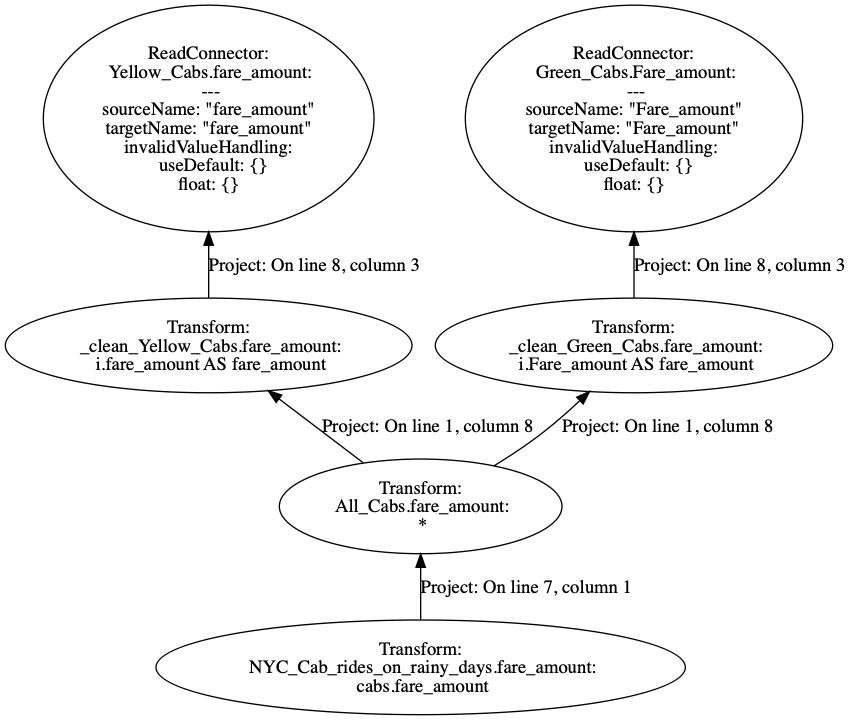

In [12]:
final = A.get_component(DATA_SERVICE, DATAFLOW, DEST_COMPONENT)
G = DotGraphCollector()
g.columns(final)
G.collect_graph(GraphNode(g.make_node(component=final, column=DEST_COLUMN)), incoming_nodes(g))
G.G.graph_attr['rankdir'] = 'BT'
G.draw('upstream_lineage.png')

from IPython.display import Image
Image(filename='upstream_lineage.png')

In [13]:
from IPython.display import display, HTML
G = PandasTableCollector()
G.collect_graph(GraphNode(g.make_node(component=final, column=DEST_COLUMN)), incoming_nodes(g))
df = G.to_df()
display(df)

,Start Comp,Start Col,Exp,End Comp,End Col
0,NYC_Cab_rides_on_rainy_days,fare_amount,"On line 7, column 1",All_Cabs,fare_amount
1,All_Cabs,fare_amount,"On line 1, column 8",_clean_Yellow_Cabs,fare_amount
2,All_Cabs,fare_amount,"On line 1, column 8",_clean_Green_Cabs,fare_amount
3,_clean_Green_Cabs,fare_amount,"On line 8, column 3",Green_Cabs,Fare_amount
4,_clean_Yellow_Cabs,fare_amount,"On line 8, column 3",Yellow_Cabs,fare_amount


# Use Position information to decorate sql queries
For SQL queries, we provide the position in the query where the input is referenced for each lineage edge. We also provide the position in the query where each output column is generated. Here this is demonstrated by highlighting and selecting each individual piece.

In [14]:
class Color(object):
    @staticmethod
    def make(name, code):
        return Color(name, f'\u001b[38;5;{code:0d}m')
    def __init__(self, name, escape_sequence):
        self.name = name
        self.escape_sequence = escape_sequence

    def __call__(self, text):
        return self.escape_sequence + text + COLORS['no_color'].escape_sequence

COLORS = {}
for color in [
        Color('no_color', '\033[0m'),
        Color('yellow', '\033[1;33m'),
        Color('red', '\033[1;31m'),
        Color('cyan', '\033[1;36m'),
        Color('green', '\033[1;32m')]:
    COLORS[color.name] = color

class Inserter:
    def __init__(self, original_text):
        self.original_text = original_text
        # Dict[pos, length]
        self.insertions = {}
        self.current_text = original_text

    def insert(self, pos, new_text):
        assert pos >= 0 and pos <= len(self.original_text)
        cur_pos = pos + sum(i[1] for i in self.insertions.items() if i[0] < pos)
        self.insertions[pos] = self.insertions.get(pos, 0) + len(new_text)
        self.current_text = self.current_text[:cur_pos] + new_text + self.current_text[cur_pos:]
        return self.current_text
    
    def map(self, pos):
        return pos + sum(i[1] for i in self.insertions.items() if i[0] < pos)

class Highlighter:
    def __init__(self, original_text):
        self.inserter = Inserter(original_text)

    @property
    def content(self):
        return self.inserter.current_text
    
    def select(self, start, end):
        start = max(start, 0)
        pref, suff = '', ''
        if start > 0:
            pref = ' ...'
        end = min(end, len(self.inserter.original_text))
        if end < len(self.inserter.original_text):
            suff = '... '
        i = self.inserter.map(start)
        j = self.inserter.map(end)
        return pref + self.inserter.current_text[i:j] + suff

    def highlight(self, start, end, color: Color):
        self.inserter.insert(start, color.escape_sequence)
        self.inserter.insert(end, COLORS['no_color'].escape_sequence)


## Colorizing the input column in the output column

In [15]:
attr_build = A.get_component(DATA_SERVICE, DATAFLOW, SOURCE_COMPONENT)
succs = {}
for e in g.out_edges(attr_build, SOURCE_COLUMN):
    outs = succs.get((e.start, e.end), [])
    succs[(e.start, e.end)] = outs
    if e.selection:
        i = e.selection.start.index
        j = e.selection.end.index
        exp = e.end.get_component_node.expression
        if e.type == 'Project':
            if len(outs) > 0:
                h, _, _ = outs[0]
            else:
                h = Highlighter(exp)
                k = e.end.selection.start.index
                l = e.end.selection.end.index
                outs.append((h, k, l))
            h.highlight(i, j, COLORS['red'])
        else:
            h = Highlighter(exp)
            h.highlight(i, j, COLORS['green'])
            outs.append((h, i-35, j+35))

for ((start, end), outs) in succs.items():
    for (h, k, l) in outs:
        print(COLORS['cyan'](str(start) + ' -> ' + str(end)) + ':')
        print(h.select(k, l))
        print('\n\n')

Yellow_Cabs.tpep_dropoff_datetime -> _clean_Yellow_Cabs.dropoff_datetime:
 ...TIMESTAMP(i.tpep_dropoff_datetime) AS dropoff_datetime... 





### Colorizing all the input column references for a Component

In [16]:
import random
an_attr = A.get_component(DATA_SERVICE, DATAFLOW, SQL_COMPONENT)

hs = []
input_cols = {}
def color_gen():
    i = 0
    def advance(name):
        nonlocal i
        i += 1
        i %= 256
        color = Color.make(name, i)
        return color
    return advance
gen_color = color_gen()
def process(edges):
    grouped_edges = [
        (t, list(start_edges)) for t, start_edges in 
         groupby(edges, lambda e: (e.start, e.type))
    ]
    for ((start, type), start_edges) in grouped_edges:
        if start in input_cols:
            color = input_cols.get(start)
        else:
            color = gen_color(col.name)
            input_cols[start] = color
        for start_edge in start_edges:
            if len(hs) == 0:
                hs.append(Highlighter(start_edge.end.get_component_node.expression))
            h = hs[0]
            if start_edge.selection:
                h.highlight(start_edge.selection.start.index, start_edge.selection.end.index, color)

for col in g.columns(an_attr):
    process(g.in_edges(an_attr, col.name))  
process(g.in_edges(an_attr))
    

for h in hs:
    print(h.content)

SELECT
  i.VendorID,
  TIMESTAMP(i.tpep_pickup_datetime) AS pickup_datetime,
  TIMESTAMP(i.tpep_dropoff_datetime) AS dropoff_datetime,
  i.RatecodeID AS ratecodeID,
  i.passenger_count AS passenger_count,
  i.trip_distance AS trip_distance,
  i.fare_amount AS fare_amount,
  i.mta_tax AS mta_tax,
  i.tip_amount AS tip_amount,
  i.tolls_amount AS tolls_amount,
  i.improvement_surcharge AS improvement_surcharge,
  i.total_amount AS total_amount,
  i.payment_type AS payment_type,
  'yellow' AS cab_type,
  DATE_TRUNC('DAY', TIMESTAMP(i.tpep_pickup_datetime)) AS pickup_date
FROM
  ${0} AS i
WHERE
  i.trip_distance > 0



## Lineage graphs for Write Connectors

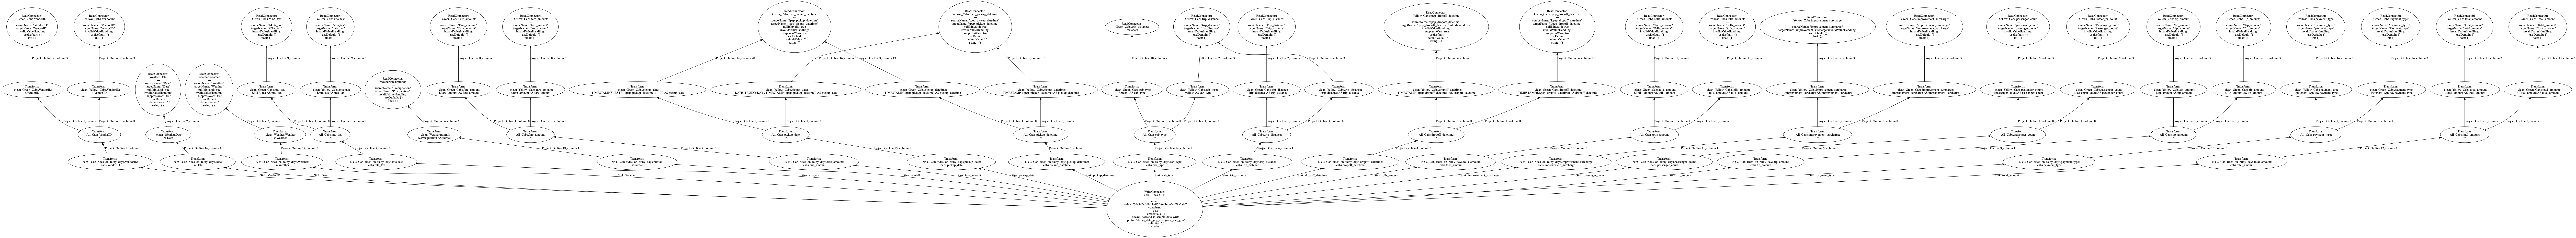

In [17]:
from ascend.model import WriteConnector
for component in A.get_dataflow(DATA_SERVICE, DATAFLOW).list_components():
    if not isinstance(component, WriteConnector):
        continue
    # print(g.in_edges(component=component))
    G = DotGraphCollector()
    f = incoming_nodes(g)
    def filtered_incoming(n):
        primary = f(n)
        if len(primary) == 0 and isinstance(n.orig, lin.ColumnNode):
            # when we hit a column that as no inputs, we check its component
            primary = f(GraphNode(n.orig.component_node))
        return [(s, e) for s, e in primary if isinstance(s.orig, lin.ColumnNode)]
    G.collect_graph(GraphNode(g.make_node(component=component)), filtered_incoming)
    G.G.graph_attr['rankdir'] = 'BT'
    file_name = f'upstream_of_{component.component_id}.png'
    G.draw(file_name)
    display(Image(filename=file_name))